# Rede Neural para prever o preço de carros usados.

O objetivo desse tutorial é demonstrar para iniciantes em
Deep Learning como criar uma rede neural simples para prever
o preço de carros usados.

Esse exercício utiliza uma adaptação do dataset
[100,000 UK Used Car Data set](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes).

Vamos usar *tensorflow*, *pandas* e *keras* para essa tarefa.
A próxima célula importa essas bibliotecas.

In [101]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

## Carregando o dataset

Vamos carregar os dados que iremos usar durante esse tutorial de um
[arquivo csv para um dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).

O arquivo onde está o nosso dataset é o `used_cars.csv`.
Ele contém dados de venda de veículos Volkswagen usados.

In [102]:
raw_dataset = pd.read_csv('used_cars.csv')
raw_dataset

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,2019,17000,Manual,8000,Diesel,145,57.7,1.6
1,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
2,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
3,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
4,2017,16491,Automatic,20693,Petrol,20,60.1,1.4
...,...,...,...,...,...,...,...,...
4858,2015,11750,Manual,79000,Diesel,20,67.3,2.0
4859,2016,11950,Automatic,41725,Petrol,30,53.3,1.4
4860,2017,12950,Automatic,44837,Diesel,20,67.3,2.0
4861,2014,11299,Manual,25495,Petrol,30,53.3,1.4


O nosso dataset tem 4.863 linhas com 8 colunas.
No jargão de Deep Learning chamamos cada linha do dataset de
`exemplo` e cada coluna de `feature`.

Agora que os nossos **dados brutos** estão carregados em um
dataframe pandas, é sempre uma boa prática deixa-los
intactos e realizar uma cópia deles para outro dataframe
onde vamos trabalhar as nossas transformações.

In [103]:
dataset = raw_dataset.copy()
dataset.head()

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,2019,17000,Manual,8000,Diesel,145,57.7,1.6
1,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
2,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
3,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
4,2017,16491,Automatic,20693,Petrol,20,60.1,1.4


## One-Hot-Encoding


In [104]:
def one_hot_encode(ds, feature):
  column = ds.pop(feature)
  one_hot_encoded = pd.get_dummies(column, prefix=feature)
  dataframe = pd.merge(
      left=ds,
      right=one_hot_encoded,
      left_index=True,
      right_index=True
  )
  return dataframe

In [105]:
dataset = one_hot_encode(ds=dataset, feature='transmission')
dataset = one_hot_encode(ds=dataset, feature='fuelType')
dataset

,year,price,mileage,tax,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2019,17000,8000,145,57.7,1.6,0,1,0,1,0,0,0
1,2019,36000,4000,145,32.8,2.0,1,0,0,0,0,0,1
2,2015,19390,20031,200,40.4,2.0,1,0,0,0,0,0,1
3,2019,16290,14821,145,44.8,1.0,1,0,0,0,0,0,1
4,2017,16491,20693,20,60.1,1.4,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,2015,11750,79000,20,67.3,2.0,0,1,0,1,0,0,0
4859,2016,11950,41725,30,53.3,1.4,1,0,0,0,0,0,1
4860,2017,12950,44837,20,67.3,2.0,1,0,0,1,0,0,0
4861,2014,11299,25495,30,53.3,1.4,0,1,0,0,0,0,1


In [106]:
len(dataset.keys())

13

## Criação dos datasets de treinamento e teste

In [107]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [108]:
len(train_dataset.index), len(test_dataset.index)

(3890, 973)

In [109]:
# Retirando os labels
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

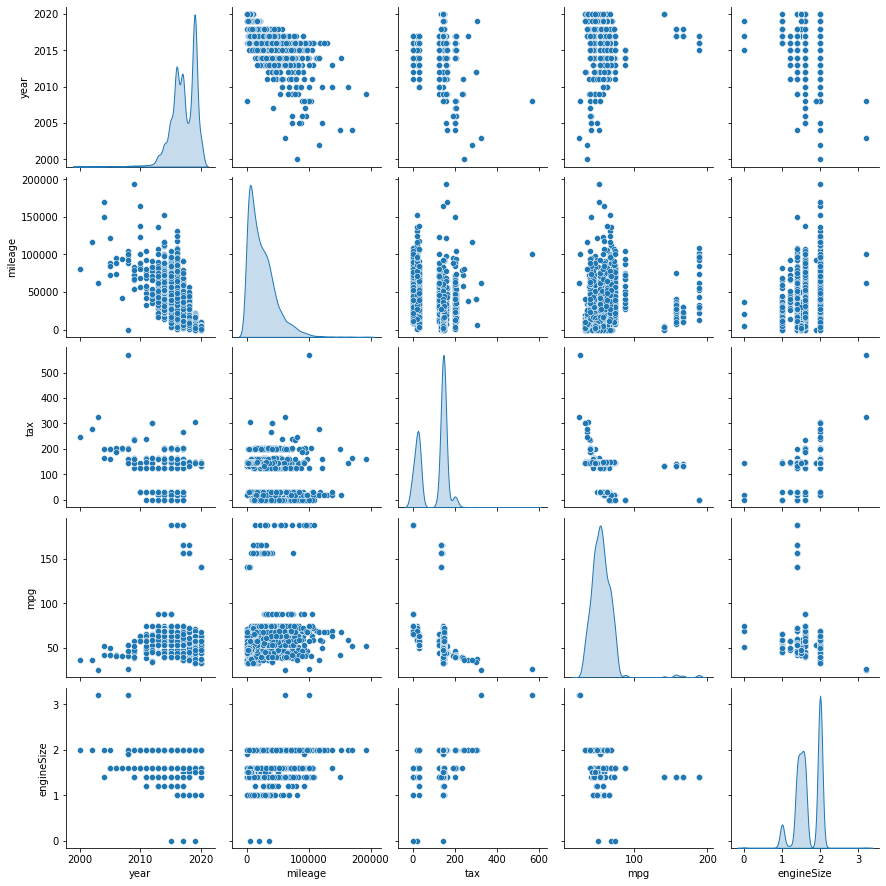

In [110]:
sns.pairplot(train_dataset[['year', 'mileage', 'tax', 'mpg', 'engineSize']], diag_kind='kde')

In [111]:
train_stats = train_dataset.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,3890.0,2017.137532,2.063745,2000.0,2016.0,2017.0,2019.0,2020.0
mileage,3890.0,24508.412596,21963.680580,1.0,7100.0,19194.0,35336.0,193000.0
tax,3890.0,100.799486,65.392211,0.0,30.0,145.0,145.0,570.0
mpg,3890.0,56.181388,17.715311,24.6,47.1,53.3,62.8,188.3
engineSize,3890.0,1.667763,0.306599,0.0,1.5,1.6,2.0,3.2
transmission_Automatic,3890.0,0.120051,0.325063,0.0,0.0,0.0,0.0,1.0
transmission_Manual,3890.0,0.605656,0.488772,0.0,0.0,1.0,1.0,1.0
transmission_Semi-Auto,3890.0,0.274293,0.446215,0.0,0.0,0.0,1.0,1.0
fuelType_Diesel,3890.0,0.423393,0.494160,0.0,0.0,0.0,1.0,1.0
fuelType_Hybrid,3890.0,0.017738,0.132014,0.0,0.0,0.0,0.0,1.0


## Reescalonamento dos dados

Uma rede neural náo *exige* que os dados
estejam normalizados para funcionar.
No entanto `features` com escalas muito diferentes
podem afetar o aprendizado da rede.

Por exemplo, neste dataset temos uma `feature`
chamada `engineSize` que varia entre 0 e 3,55 e
outra chamada `mileage` que varia de 1 a 193.000.
Essa diferença de tamanhos fará com que a feature
`mileage` tenha mais impacto no aprendizado da rede
do que a feature `engineSize`.

Para evitar esse tipo de problema podemos usar dois
métodos:

- Normalização
- Padronização

A **padronização** dos dados consiste em transformá-los
para que tenham a média zero e variem em mais ou menos um
desvio padrão.

$$ X_{pad} = \frac{X - \mu}{\sigma} $$

A **normalização** reescala os dados num intervalo que
varia de 0 a 1.

$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

Mais informações sobre esse importante tópico
pode ser encontrados em
[How, When, and Why Should You Normalize / Standardize / Rescale Your Data?](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)

O trecho de código abaixo implementa a padronização.
O código da normalização está comentado. Eu sugiro que
você experimente com os dois métodos e observe os efeitos
sobre os resultados desta rede.

In [112]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
    # return (x - train_stats['min']) / (train_stats['max'] - train_stats['min'])

In [113]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Observe como os dados agora têm média próxima de zero e desvio padrão 1.

In [114]:
normed_train_data.describe()

,year,mileage,tax,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03
mean,-1.899720e-14,2.739882e-17,3.470517e-17,4.794794e-16,-1.032022e-16,3.561847e-17,7.078029e-17,6.393058e-18,-5.023117e-18,-3.287858e-17,-2.283235e-18,1.013756e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.304094e+00,-1.115815e+00,-1.541460e+00,-1.782717e+00,-5.439559e+00,-3.693169e-01,-1.239136e+00,-6.147109e-01,-8.567938e-01,-1.343632e-01,-7.187927e-02,-1.113761e+00
25%,-5.511980e-01,-7.926000e-01,-1.082690e+00,-5.126293e-01,-5.471756e-01,-3.693169e-01,-1.239136e+00,-6.147109e-01,-8.567938e-01,-1.343632e-01,-7.187927e-02,-1.113761e+00
50%,-6.664202e-02,-2.419637e-01,6.759293e-01,-1.626496e-01,-2.210167e-01,-3.693169e-01,8.068062e-01,-6.147109e-01,-8.567938e-01,-1.343632e-01,-7.187927e-02,8.976276e-01
75%,9.024699e-01,4.929769e-01,6.759293e-01,3.736097e-01,1.083619e+00,-3.693169e-01,8.068062e-01,1.626363e+00,1.166842e+00,-1.343632e-01,-7.187927e-02,8.976276e-01
max,1.387026e+00,7.671373e+00,7.175174e+00,7.457877e+00,4.997526e+00,2.707006e+00,8.068062e-01,1.626363e+00,1.166842e+00,7.440603e+00,1.390864e+01,8.976276e-01


In [115]:
def build_model():
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(units=9,
                                                     activation='relu',
                                                     input_shape=[len(train_dataset.keys())]),
                               tf.keras.layers.Dense(units=1)
  ])

  model.compile(
      loss='mse',
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=['mae', 'mse']
  )

  return model

In [116]:
model = build_model()

In [117]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 10        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


In [118]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.06798565],
       [ 0.53545266],
       [-0.15585752],
       [ 0.46778944],
       [ 0.11054844],
       [ 1.3568814 ],
       [-0.0629672 ],
       [-0.09120241],
       [ 0.04898191],
       [ 0.75201976]], dtype=float32)

In [119]:
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=1000,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    verbose=0
)

In [120]:
hist = pd.DataFrame(history.history)
hist['EPOCH'] = history.epoch
hist.tail(10)

,loss,mae,mse,val_loss,val_mae,val_mse,EPOCH
249,2831888.00,1254.712646,2831888.00,2892010.00,1238.908936,2892010.00,249
250,2831230.25,1248.754150,2831230.25,2886092.75,1238.318481,2886092.75,250
251,2831191.50,1250.803711,2831191.50,2889677.00,1239.446533,2889677.00,251
252,2831483.00,1253.610107,2831483.00,2890603.50,1239.492554,2890603.50,252
253,2829102.50,1249.467407,2829102.50,2885485.25,1238.243530,2885485.25,253
254,2830736.50,1252.170654,2830736.50,2885743.25,1238.131226,2885743.25,254
255,2826847.00,1252.874756,2826847.00,2889135.50,1237.852539,2889135.50,255
256,2829565.00,1249.391724,2829565.00,2888816.25,1238.652222,2888816.25,256
257,2830371.00,1251.143921,2830371.00,2890400.50,1239.036865,2890400.50,257
258,2826678.50,1250.424072,2826678.50,2890298.50,1239.084106,2890298.50,258


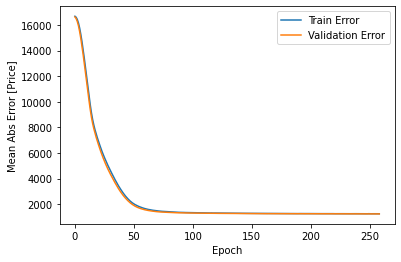

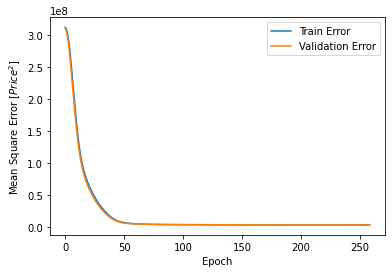

In [121]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['EPOCH'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Price]')
  plt.plot(hist['EPOCH'], hist['mae'], label='Train Error')
  plt.plot(hist['EPOCH'], hist['val_mae'], label='Validation Error')
  plt.legend()
  # plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['EPOCH'], hist['mse'], label='Train Error')
  plt.plot(hist['EPOCH'], hist['val_mse'], label='Validation Error')
  plt.legend()
  # plt.ylim([0,20])

plot_history(history)

In [122]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

loss, mae, mse

(2539805.25, 1207.5843505859375, 2539805.25)

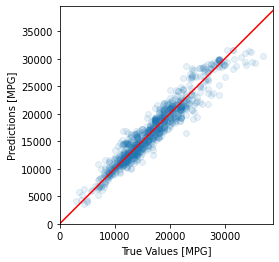

In [123]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([0, 40_000], [0, 40_000], color='r')

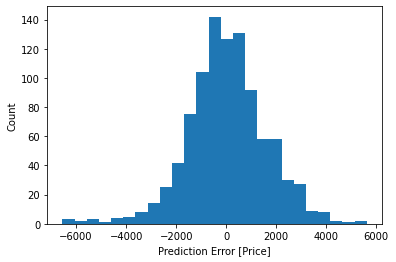

In [124]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Price]')
_ = plt.ylabel('Count')